# Import dependencies

In [37]:
# Re-loads all imports every time the cell is ran. 
%load_ext autoreload
%autoreload 2

from time import time

import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.5f}'.format

from IPython.display import display

# Sklearn tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Neural Networks
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers.csv_logs import CSVLogger

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt


# Prediction task

We are going to predict hourly levels of global active power one step ahead.

# TimeseriesDataset


In [38]:
class TimeseriesDataset(Dataset):   
    '''
    Custom Dataset subclass. 
    Serves as input to DataLoader to transform X 
      into sequence data using rolling window. 
    DataLoader using this dataset will output batches 
      of `(batch_size, seq_len, n_features)` shape.
    Suitable as an input to RNNs. 
    '''
    def __init__(self, X: np.ndarray, y: np.ndarray, seq_len: int = 1):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float()
        self.seq_len = seq_len

    def __len__(self):
        return self.X.__len__() - (self.seq_len-1)

    def __getitem__(self, index):
        return (self.X[index:index+self.seq_len], self.y[index+self.seq_len-1])

# DataModule

In [39]:
class PowerConsumptionDataModule(pl.LightningDataModule):
    '''
    PyTorch Lighting DataModule subclass:
    https://pytorch-lightning.readthedocs.io/en/latest/datamodules.html

    Serves the purpose of aggregating all data loading 
      and processing work in one place.
    '''
    
    def __init__(self, seq_len = 1, batch_size = 128, num_workers=0):
        super().__init__()
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.X_train = None
        self.y_train = None
        self.X_val = None
        self.y_val = None
        self.X_test = None
        self.X_test = None
        self.columns = None
        self.preprocessing = None

    def prepare_data(self):
        pass

    def setup(self, stage=None):
        '''
        Data is resampled to hourly intervals.
        Both 'np.nan' and '?' are converted to 'np.nan'
        'Date' and 'Time' columns are merged into 'dt' index
        '''

        if stage == 'fit' and self.X_train is not None:
            return 
        if stage == 'test' and self.X_test is not None:
            return
        if stage is None and self.X_train is not None and self.X_test is not None:  
            return
        
        path = '/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt'
        
        df = pd.read_csv(
            path, 
            sep=';', 
            parse_dates={'dt' : ['Date', 'Time']}, 
            infer_datetime_format=True, 
            low_memory=False, 
            na_values=['nan','?'], 
            index_col='dt'
        )

        df_resample = df.resample('h').mean()

        X = df_resample.dropna().copy()
        y = X['Global_active_power'].shift(-1).ffill()
        self.columns = X.columns


        X_cv, X_test, y_cv, y_test = train_test_split(
            X, y, test_size=0.2, shuffle=False
        )
    
        X_train, X_val, y_train, y_val = train_test_split(
            X_cv, y_cv, test_size=0.25, shuffle=False
        )

        preprocessing = StandardScaler()
        preprocessing.fit(X_train)

        if stage == 'fit' or stage is None:
            self.X_train = preprocessing.transform(X_train)
            self.y_train = y_train.values.reshape((-1, 1))
            self.X_val = preprocessing.transform(X_val)
            self.y_val = y_val.values.reshape((-1, 1))

        if stage == 'test' or stage is None:
            self.X_test = preprocessing.transform(X_test)
            self.y_test = y_test.values.reshape((-1, 1))
        

    def train_dataloader(self):
        train_dataset = TimeseriesDataset(self.X_train, 
                                          self.y_train, 
                                          seq_len=self.seq_len)
        train_loader = DataLoader(train_dataset, 
                                  batch_size = self.batch_size, 
                                  shuffle = False, 
                                  num_workers = self.num_workers)
        
        return train_loader

    def val_dataloader(self):
        val_dataset = TimeseriesDataset(self.X_val, 
                                        self.y_val, 
                                        seq_len=self.seq_len)
        val_loader = DataLoader(val_dataset, 
                                batch_size = self.batch_size, 
                                shuffle = False, 
                                num_workers = self.num_workers)

        return val_loader

    def test_dataloader(self):
        test_dataset = TimeseriesDataset(self.X_test, 
                                         self.y_test, 
                                         seq_len=self.seq_len)
        test_loader = DataLoader(test_dataset, 
                                 batch_size = self.batch_size, 
                                 shuffle = False, 
                                 num_workers = self.num_workers)

        return test_loader

# Model
Implement LSTM regressor using pytorch-lighting module

In [40]:
class LSTMRegressor(pl.LightningModule):
    '''
    Standard PyTorch Lightning module:
    https://pytorch-lightning.readthedocs.io/en/latest/lightning_module.html
    '''
    def __init__(self, 
                 n_features, 
                 hidden_size, 
                 seq_len, 
                 batch_size,
                 num_layers, 
                 dropout, 
                 learning_rate,
                 criterion):
        super(LSTMRegressor, self).__init__()
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.criterion = criterion
        self.learning_rate = learning_rate

        self.lstm = nn.LSTM(input_size=n_features, 
                            hidden_size=hidden_size,
                            num_layers=num_layers, 
                            dropout=dropout, 
                            batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # lstm_out = (batch_size, seq_len, hidden_size)
        lstm_out, _ = self.lstm(x)
        y_pred = self.linear(lstm_out[:,-1])
        return y_pred
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        result = pl.TrainResult(loss)
        result.log('train_loss', loss)
        return result

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        result = pl.EvalResult(checkpoint_on=loss)
        result.log('val_loss', loss)
        return result
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        result = pl.EvalResult()
        result.log('test_loss', loss)
        return result

# Parameters

In [41]:
'''
All parameters are aggregated in one place.
This is useful for reporting experiment params to experiment tracking software
'''

p = dict(
    seq_len = 24,
    batch_size = 70, 
    criterion = nn.MSELoss(),
    max_epochs = 10,
    n_features = 7,
    hidden_size = 100,
    num_layers = 1,
    dropout = 0.2,
    learning_rate = 0.001,
)

# Train loop

In [42]:
seed_everything(42)

csv_logger = CSVLogger('./', name='lstm', version='0'),

trainer = Trainer(
    max_epochs=p['max_epochs'],
    logger=csv_logger,
    gpus=1,
    row_log_interval=1,
    progress_bar_refresh_rate=2,
)

model = LSTMRegressor(
    n_features = p['n_features'],
    hidden_size = p['hidden_size'],
    seq_len = p['seq_len'],
    batch_size = p['batch_size'],
    criterion = p['criterion'],
    num_layers = p['num_layers'],
    dropout = p['dropout'],
    learning_rate = p['learning_rate']
)

dm = PowerConsumptionDataModule(
    seq_len = p['seq_len'],
    batch_size = p['batch_size']
)

trainer.fit(model, dm)
trainer.test(model, datamodule=dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Experiment logs directory ./lstm/0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 43 K  
2 | linear    | Linear  | 101   
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Saving latest checkpoint..


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(0.2435, device='cuda:0')}
--------------------------------------------------------------------------------



[{'test_loss': 0.24348831176757812}]

# Plot report

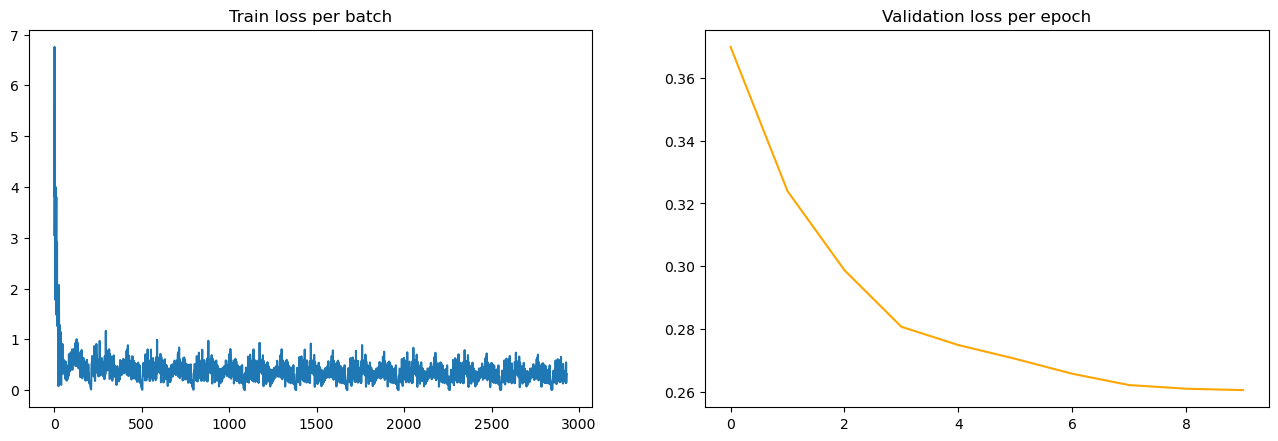

MSE:
Train loss: 0.319
Val loss:   0.260
Test loss:  0.243


In [43]:
metrics = pd.read_csv('./lstm/0/metrics.csv')
train_loss = metrics[['train_loss', 'step', 'epoch']][~np.isnan(metrics['train_loss'])]
val_loss = metrics[['val_loss', 'epoch']][~np.isnan(metrics['val_loss'])]
test_loss = metrics['test_loss'].iloc[-1]

fig, axes = plt.subplots(1, 2, figsize=(16, 5), dpi=100)
axes[0].set_title('Train loss per batch')
axes[0].plot(train_loss['step'], train_loss['train_loss'])
axes[1].set_title('Validation loss per epoch')
axes[1].plot(val_loss['epoch'], val_loss['val_loss'], color='orange')
plt.show(block = True)

print('MSE:')
print(f"Train loss: {train_loss['train_loss'].iloc[-1]:.3f}")
print(f"Val loss:   {val_loss['val_loss'].iloc[-1]:.3f}")
print(f'Test loss:  {test_loss:.3f}')

# 예측

In [63]:
# 모델 디바이스 확인 (GPU가 있으면 GPU, 없으면 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 테스트 데이터 로더에서 첫 배치를 가져옵니다
test_loader = dm.test_dataloader()
test_batch = next(iter(test_loader))

# 입력 데이터를 추출하고 디바이스로 이동
x_test, _ = test_batch  # 실제 타겟 값(y_actual)은 무시
x_test = x_test.to(device)

# 모델을 사용하여 예측값 생성
model.train()  # 모델을 학습 모드로 설정 (업데이트 가능하도록)
y_predicted = model(x_test).squeeze()  # 예측값 생성

# 첫 번째 데이터의 예측값
predicted_value = y_predicted[0].item()

# 사용자 임의로 실제 값을 제공
actual_value = float(input("임의의 실제 값을 입력하세요: "))

# 예측값과 실제 값을 텐서로 변환
y_actual = torch.tensor([actual_value], dtype=torch.float32, device=device)

# 손실 함수 정의 (MSELoss 사용)
criterion = torch.nn.MSELoss()

# 손실 계산 (y_predicted는 requires_grad=True 상태)
loss = criterion(y_predicted[0].unsqueeze(0), y_actual)

# 모델 업데이트를 위한 옵티마이저 정의
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 역전파를 통해 가중치 업데이트
optimizer.zero_grad()  # 기존의 그래디언트 초기화
loss.backward()  # 역전파 수행
optimizer.step()  # 가중치 업데이트

print(f"모델 예측 값: {predicted_value}")
print(f"오차: {actual_value - predicted_value}")
print(f"손실 (MSE): {loss.item()}")

임의의 실제 값을 입력하세요:  0.2


모델 예측 값: 0.2794632017612457
오차: -0.07946320176124572
손실 (MSE): 0.006314400117844343


In [70]:
import pandas as pd

# 데이터 로드 및 전처리
path = '/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt'
df = pd.read_csv(
    path, 
    sep=';', 
    parse_dates={'dt': ['Date', 'Time']}, 
    infer_datetime_format=True, 
    low_memory=False, 
    na_values=['nan', '?'], 
    index_col='dt'
)

# 10분 단위로 리샘플링하여 평균값 계산
df_resampled = df.resample('10T').mean()

# 전력 소비량 계산 (kWh 단위)
df_resampled['Energy_kWh'] = df_resampled['Global_active_power']


# 결과 출력
print("10분 단위 소비량 (kWh):")
#print(df_resampled['Energy_kWh'].head(10))

# 2010년 데이터만 필터링
df_2010 = df_resampled.loc['2010']

# 결과 출력
print(df_2010['Energy_kWh'])

10분 단위 소비량 (kWh):
dt
2010-01-01 00:00:00   1.71360
2010-01-01 00:10:00   1.61940
2010-01-01 00:20:00   1.26120
2010-01-01 00:30:00   0.66100
2010-01-01 00:40:00   0.63040
                        ...  
2010-11-26 20:20:00   1.05360
2010-11-26 20:30:00   0.97540
2010-11-26 20:40:00   0.95840
2010-11-26 20:50:00   0.97820
2010-11-26 21:00:00   0.93467
Freq: 10T, Name: Energy_kWh, Length: 47503, dtype: float64


In [66]:
# 모델 디바이스 확인 (GPU가 있으면 GPU, 없으면 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 모델을 학습 모드로 설정
model.train()

# 옵티마이저 정의
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# 예제 데이터프레임
import pandas as pd
"""data = {
    "dt": [
        "2010-01-01 00:00:00", 
        "2010-01-01 00:10:00", 
        "2010-01-01 00:20:00", 
        "2010-01-01 00:30:00", 
        "2010-01-01 00:40:00"
    ],
    "actual_value": [1.71360, 1.61940, 1.26120, 0.66100, 0.63040]
}"""
data = df_2010['Energy_kWh']

df = pd.DataFrame(data)
df["dt"] = pd.to_datetime(df["dt"])

# 반복 학습
for _, row in df.iterrows():
    # 실제 값과 시간
    actual_value = row["actual_value"]
    timestamp = row["dt"]

    # 테스트 데이터 로더에서 첫 배치를 가져옵니다
    test_loader = dm.test_dataloader()
    test_batch = next(iter(test_loader))

    # 입력 데이터를 추출하고 디바이스로 이동
    x_test, _ = test_batch  # 실제 타겟 값(y_actual)은 무시
    x_test = x_test.to(device)

    # 모델을 사용하여 예측값 생성
    y_predicted = model(x_test).squeeze()  # 예측값 생성

    # 첫 번째 데이터의 예측값
    predicted_value = y_predicted[0].item()

    # 실제 값과 예측값을 텐서로 변환
    y_actual = torch.tensor([actual_value], dtype=torch.float32, device=device)

    # 손실 계산
    loss = criterion(y_predicted[0].unsqueeze(0), y_actual)

    # 역전파를 통해 모델 업데이트
    optimizer.zero_grad()  # 기존의 그래디언트 초기화
    loss.backward()  # 역전파 수행
    optimizer.step()  # 가중치 업데이트

    print(f"[{timestamp}]")
    print(f"모델 예측 값: {predicted_value}")
    print(f"실제 값: {actual_value}")
    print(f"오차: {actual_value - predicted_value}")
    print(f"손실 (MSE): {loss.item()}\n")


[2010-01-01 00:00:00]
모델 예측 값: 0.7171869874000549
실제 값: 1.7136
오차: 0.9964130125999451
손실 (MSE): 0.992838978767395

[2010-01-01 00:10:00]
모델 예측 값: 0.8729202151298523
실제 값: 1.6194
오차: 0.7464797848701477
손실 (MSE): 0.5572320818901062

[2010-01-01 00:20:00]
모델 예측 값: 1.053624153137207
실제 값: 1.2612
오차: 0.20757584686279307
손실 (MSE): 0.04308771342039108

[2010-01-01 00:30:00]
모델 예측 값: 1.2412452697753906
실제 값: 0.661
오차: -0.5802452697753906
손실 (MSE): 0.33668455481529236

[2010-01-01 00:40:00]
모델 예측 값: 1.2753946781158447
실제 값: 0.6304
오차: -0.6449946781158448
손실 (MSE): 0.41601812839508057



In [35]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler

# 임의의 테스트 데이터 생성
def generate_test_data():
    data = {
        "Date": ["16/12/2006", "16/12/2006", "16/12/2006", "16/12/2006", "16/12/2006"],
        "Time": ["17:24:00", "17:25:00", "17:26:00", "17:27:00", "17:28:00"],
        "Global_active_power": [4.216, 5.360, 5.374, 5.388, 3.666],
        "Global_reactive_power": [0.418, 0.436, 0.498, 0.502, 0.528],
        "Voltage": [234.840, 233.630, 233.290, 233.740, 235.680],
        "Global_intensity": [18.400, 23.000, 23.000, 23.000, 15.800],
        "Sub_metering_1": [0.000, 0.000, 0.000, 0.000, 0.000],
        "Sub_metering_2": [1.000, 1.000, 2.000, 1.000, 1.000],
        "Sub_metering_3": [17.000, 16.000, 17.000, 17.000, 17.000],
    }

    df = pd.DataFrame(data)

    # Date와 Time을 dt로 합치기
    df["dt"] = pd.to_datetime(df["Date"] + " " + df["Time"], format="%d/%m/%Y %H:%M:%S")
    df.set_index("dt", inplace=True)

    # Active_energy_other 계산
    df["Active_energy_other"] = (
        (df["Global_active_power"] * 1000 / 60) -
        df["Sub_metering_1"] -
        df["Sub_metering_2"] -
        df["Sub_metering_3"]
    )

    # 필요한 컬럼만 선택
    df = df["Active_energy_other"]

    # 시간 정보 추가
    df = df.to_frame()
    df["year"] = df.index.year
    df["month"] = df.index.month
    df["day"] = df.index.day
    df["hour"] = df.index.hour

    return df

# 테스트 데이터 생성
test_data = generate_test_data()

# 데이터 스케일링
scaler = StandardScaler()
X_test = scaler.fit_transform(test_data[["year", "month", "day", "hour"]].values)
y_test = test_data["Active_energy_other"].values

# 텐서로 변환 (3차원으로 확장)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)  # (batch_size, seq_len=1, n_features)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# 마스킹하여 일부 값을 예측하도록 설정
y_masked = y_test_tensor.clone()
y_masked[::2] = float('nan')  # 예: 짝수 인덱스의 값을 마스킹

# 모델 예측 (실제 모델 사용)
model.eval()  # 모델을 평가 모드로 전환
with torch.no_grad():
    predicted = model(X_test_tensor)  # 모델을 사용한 예측 수행

# 마스킹된 값과 모델 예측값의 차이 계산
masked_indices = torch.isnan(y_masked)
differences = y_test_tensor[masked_indices] - predicted[masked_indices].squeeze()

# 출력
print("Test Features (X):", X_test_tensor)
print("Test Labels (y):", y_test_tensor)
print("Predicted Values:", predicted)
print("Differences for Masked Values:", differences)

RuntimeError: Input and parameter tensors are not at the same device, found input tensor at cpu and parameter tensor at cuda:0